# Quantized Training of LightGBM

## 概要

LightGBMのような最近のGBDTで使われている決定木では、葉の出力$w$は誤差関数の2次のテイラー近似をもとに、以下のように計算される（このあたりは[Chen & Guestrin, 2016](https://dl.acm.org/doi/pdf/10.1145/2939672.2939785)が比較的わかりやすい）

$$
w^*_s = -\frac{\sum_{i\in I_s} g_i}{\sum_{i\in I_s} h_i}
$$

ここで$g_i$は誤差関数の勾配、$h_i$は誤差関数の二次の微分である。

この$g_i, h_i$を32bitや64bitのfloatではなく、4bitなどの低ビット幅の整数で保持しよう、というのが量子化である。


## 現代的なGBDTの学習の流れ

（[Shi et al. (2022). Quantized training of gradient boosting decision trees.](https://arxiv.org/pdf/2207.09682.pdf)より）

まず、GBDTの学習の流れを再確認し、notationを決める

勾配ブースティング決定木（GBDT）は複数の決定木を組み合わせるアンサンブル学習のアプローチをとる。

各iterationでは現状の予測値に基づくGradientとHessianを計算し、負の勾配を近似するように決定木を学習する。

$k+1$回目の反復において、現状のサンプル$i$の予測値を$\hat{y}_i^k$とすると、誤差関数$l$のgradient$g_i$とhessian$h_i$は

$$
g_i=\frac{\partial l\left(\hat{y}_i^k, y_i\right)}{\partial \hat{y}_i^k},
\quad
h_i=\frac{\partial^2 l\left(\hat{y}_i^k, y_i\right)}{\left(\partial \hat{y}_i^k\right)^2}
$$

となる。

葉$s$について、葉に含まれるデータの番号（index）の集合を$I_s$とする。葉$s$における$g_i$と$h_i$のサンプルについての合計を

$$
G_s = \sum_{i\in I_s} g_i,
\quad
H_s = \sum_{i\in I_s} h_i
$$

と表記することにすると、反復$k+1$回目において木構造が固定された下で、訓練誤差は二次のテイラー近似により

$$
\mathcal{L}_{k+1} \approx \mathcal{C}+\sum_s\left(\frac{1}{2} H_s w_s^2+G_s w_s\right)
$$

と表すことができる。

ここで$\mathcal{C}$は定数で、$w_s$は葉$s$の予測値である。近似誤差の最小化により最適値が得られる

$$
w_s^*=-\frac{G_s}{H_s}, \quad \mathcal{L}_s^*=-\frac{1}{2} \cdot \frac{G_s^2}{H_s}
$$

最適な木構造を探すのは困難であるため、木は貪欲かつ反復的に訓練される。

葉$s$を2つの子$s_1, s_2$に分割するとき、近似損失の減少分は次のように計算できる。

$$
\Delta \mathcal{L}_{s \rightarrow s_1, s_2}=\mathcal{L}_s^*-\mathcal{L}_{s_1}^*-\mathcal{L}_{s_2}^*=\frac{G_{s_1}^2}{2 H_{s_1}}+\frac{G_{s_2}^2}{2 H_{s_2}}-\frac{G_s^2}{2 H_s}
$$

葉$s$にとっての最適な分割条件の探索は、すべての特徴のすべての分割候補点を数え上げて、最も損失の減少が多いものが選ばれる。

LightGBMでは最適分割点の探索を高速化するためにヒストグラムを使う。histogram based GBDTの基本的なアイデアは特徴量の値をbinsに分割する。histogramのbinsは、そのbinに含まれるデータのgradientsとhessiansの総和が記録されている。binsの境界値のみが分割候補点になる。

> Algorithm 1 Histogram Construction for Leaf $s$
> 
> Input: Gradients $\left\{g_1, \ldots, g_N\right\}$, Hessians $\left\{h_1, \ldots, h_N\right\}$ <br>
> Input: Bin data data $[N][J]$, Data indices in leaf $s$ denoted by $I_s$ <br>
> Output: Histogram ${hist}_s$ <br>
> for $i \in I_s, j \in\{1 \ldots J\}$ do <br>
>   bin $\leftarrow \operatorname{data}[i][j]$ <br>
>   $hist_s[j][bin] . g \leftarrow$  $hist_s[j][$ bin $] . g+g_i$ <br>
>   $hist_s[j][b i n] . h \leftarrow$  $hist_s[j][b i n] . h+h_i$ <br>
> end for

伝統的には$g_i$と$h_i$には32-bitの浮動小数点数が使われ、histogramへの累計には32-bitか64-bitの浮動小数点数が必要になる。


## Framework for Quantized Training

まず$g_i$と$h_i$を低ビット幅（low-bitwidth）の整数$\tilde{g}_i, \tilde{h}_i$に量子化する。

すべての訓練サンプルの$g_i$と$h_i$のレンジを、等しい長さの区間へと分割する。$B$-bit $(B \geq 2)$ 整数の勾配を使うために、$2^B - 2$個の区間を使う。各区間の最後は整数値と対応するため、全体で$2^B - 1$個の整数値になる。

1次の導関数$g_i$は正の値も負の値もとるため、半分の区間は負の値のために割り当てられ、残り半分は正の値に割り当てられる。

2次の導関数$h_i$は一般的にGBDTで使われる誤差関数のほとんどすべてが非負の値をもつため、以下の議論では$h_i \geq 0$と仮定する。

それゆえ、区間の長さは$g_i, h_i$それぞれに対して

$$
\delta_g=\frac{\max _{i \in[N]}\left|g_i\right|}{2^{B-1}-1},
\quad
\delta_h=\frac{\max _{i \in[N]} h_i}{2^B-2}
$$

となる。これにより、低ビット幅の勾配は

$$
\tilde{g}_i=\operatorname{Round}\left(\frac{g_i}{\delta_g}\right),
\quad
\tilde{h}_i=\text { Round }\left(\frac{h_i}{\delta_h}\right)
$$

で計算できる。ここで$\text{Round}()$は浮動小数点数を定数に丸める関数である。

なお、もし$h_i$が定数なら、量子化する必要はない。

詳細なrounding strategyは4.2節に書く。

Algorithm 1の$g_i, h_i$を$\tilde{g}_i, \tilde{h}_i$に置き換える。もとの勾配の和の計算は整数の和の計算に置き換えられ、histogram binsの統計量$g$と$h$は整数になる。

In [1]:
B = 2
g = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
delta_g = max([abs(gi) for gi in g]) / (2**(B-1) - 1)
tilde_g = [round(gi / delta_g) for gi in g]
tilde_g

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

分岐による損失の減少分

$$
\Delta \mathcal{L}_{s \rightarrow s_1, s_2}=\mathcal{L}_s^*-\mathcal{L}_{s_1}^*-\mathcal{L}_{s_2}^*=\frac{G_{s_1}^2}{2 H_{s_1}}+\frac{G_{s_2}^2}{2 H_{s_2}}-\frac{G_s^2}{2 H_s}
$$

の$G_{s_1}, H_{s_1}, G_{s_2}, H_{s_2}$は整数の$\tilde{G}_{s_1}, \tilde{H}_{s_1}, \tilde{G}_{s_2}, \tilde{H}_{s_2}$に置き換えられる。

我々は2から4bitの量子化された勾配が十分よい精度をもたらすことを発見した。また、6.1節と7.4.3節で議論するが、ヒストグラムにおける累積した低ビット幅の勾配には16bit整数で十分であった。それゆえ、大部分の演算は低ビット幅の整数によって行われる。浮動小数点数の演算が必要になるのは本来の勾配とヘシアンとsplit gainを計算するときだけである。とくに、split gainは

$$
\Delta \tilde{\mathcal{L}}_{s \rightarrow s_1, s_2}
=
\frac{ \left(\tilde{G}_{s_1} \delta_g\right)^2}{2 \tilde{H}_{s_1} \delta_h}
+\frac{\left(\tilde{G}_{s_2} \delta_g\right)^2}{2 \tilde{H}_{s_2} \delta_h}
-\frac{\left(\tilde{G}_s \delta_g\right)^2}{2 \tilde{H}_s \delta_h}
$$

と推定される。ここで勾配の統計量のスケールは$\delta_g$と$\delta_h$を乗じることで復元される。

Figure 1は量子化されたGBDTのワークフローを要約している。

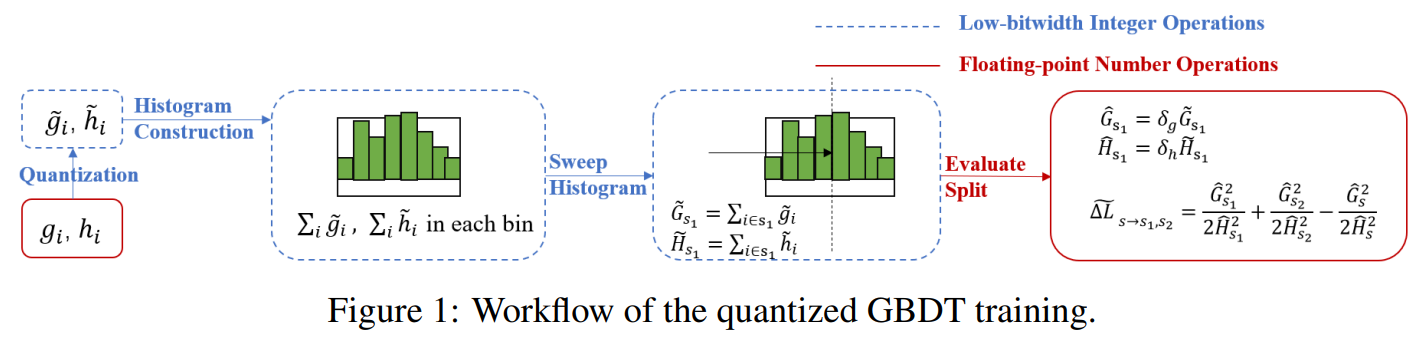

## Rounding Strategies and Leaf-Value Refitting

最も近い整数への丸め込み（round-to-nearest）

$$
\operatorname{RN}(x)= \begin{cases}\lfloor x\rfloor, & x<\lfloor x\rfloor+\frac{1}{2} \\
\lceil x\rceil, & x \geq\lfloor x\rfloor+\frac{1}{2}\end{cases}
$$

では精度が大幅に低下することがわかった。

代わりに、 **確率的な丸め込み（stochastic rounding）**

$$
\operatorname{SR}(x)=\left\{\begin{array}{lll}
\lfloor x\rfloor, & \text { w.p. } & \lceil x\rceil-x \\
\lceil x\rceil, & \text { w.p. } & x-\lfloor x\rfloor
\end{array}\right.
$$

を用いる（$\text{w.p.}$はwith probabilityの意味）。
確率的な丸め込みでは$\mathbb{E}[\widetilde{g}_i]=g_i / \delta_g$であるような値$\widetilde{g}_i$がランダムな値$\lfloor g_i / \delta_g\rfloor$か$\lceil g_i / \delta_g\rceil$をとる。


split gainは勾配の総和で計算されるため、確率的な丸め込みは総和への不偏推定量となる。すなわち

$$
\mathbb{E}[\widetilde{G} \delta_g]=G,
\quad 
\mathbb{E}[\widetilde{H} \delta_h] = H
$$

である。

確率的な丸め込みの重要性はニューラルネットの量子化学習\[13\]とDimBoost\[16\]のヒストグラム分解でも認識されている。

量子化された勾配により、最適なleaf valueは

$$
\widetilde{w}_s^*=-\frac{\widetilde{G}_s \delta_g}{\widetilde{H}_s \delta_h}
$$

となり、多くのケースで$\widetilde{w}_s^*$は良い結果をもたらすのに十分である。

しかし、ランキングなど一部の損失関数では、木の成長が止まったあとに元の勾配でleaf valueをrefittingする方法が精度を向上させることがわかった。BitBoost [8] も同様の方法をとっているが、BitBoostと違い、本手法はsplit gainのヘシアンを木の成長中も考慮するがBitBoostではヘシアンを定数として扱い真のヘシアンをleaf valueのrefittingのときだけ使う。

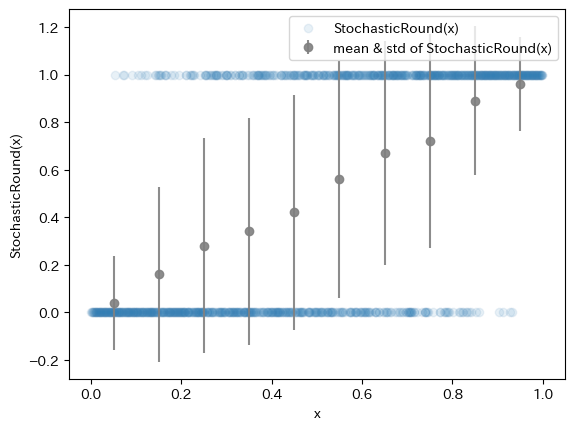

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def stochastic_round(x: float) -> int:
    f = np.floor(x)
    c = np.ceil(x)
    return np.random.choice([f, c], p=[c - x, x - f])
    
np.random.seed(0)
e = 0.001
x = np.linspace(e, 1-e, 1000)
y = [stochastic_round(xi) for xi in x]


x_c = pd.cut(x, bins=10)

def mid_value(cat):
    return cat.left + ((cat.right - cat.left) / 2)

cat_to_mid = {cat: mid_value(cat) for cat in x_c.categories}

df = pd.DataFrame({
    "x": x,
    "y": y,
    "x_c": x_c.map(cat_to_mid, na_action=None)
})
agg = df.groupby("x_c", observed=True)["y"].agg(["mean", "std"]).reset_index()

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.1, label="StochasticRound(x)", edgecolors="steelblue")
ax.errorbar(agg["x_c"], agg["mean"], yerr=agg["std"], alpha=0.9,
            fmt="o", color="gray", label="mean & std of StochasticRound(x)")
            # xerr=(x.max() - x.min()) / 10 / 2,

# for cat in x_c.categories:
#     ax.axvline(cat.left, alpha=0.5, linestyle="--", color="gray")
# ax.axvline(cat.right, alpha=0.5, linestyle="--", color="gray")

ax.set(
    xlabel="x",
    ylabel="StochasticRound(x)",
    title="",
)
ax.legend()
fig.show()

### 確率的な丸め込みによる

確率的な丸め込みにより、「split gain推定の誤差は高い確率で小さい値に制限される」というsection 5の定理が提供できる。


## 実装

注意点

- 精度を上げるため、量子化前の勾配でleaf valueを再計算する場合、計算時間もモデルのサイズも悪化する

### 実験：量子化の有無による差を比較

In [10]:
import lightgbm as lgb
print(f"{lgb.__version__=}")


def gen_dataset(seed=0):
    from sklearn.datasets import make_regression
    X, y = make_regression(n_samples=5_000, n_features=10, noise=0.5, random_state=seed)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=0)

    import lightgbm as lgb
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    return lgb_train, lgb_val, X_test, y_test


def train(params, lgb_train, lgb_val):
    logs = {}
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=100_000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100000),
            lgb.record_evaluation(logs)
        ]
    )
    return model, logs


from tqdm import tqdm
from time import time
from pathlib import Path
from sklearn.metrics import root_mean_squared_error
import joblib
import pandas as pd


def get_model_size(model):
    model_path = Path("model.joblib")
    with open(model_path, "wb") as f:
        joblib.dump(model, f)
    
    size_mb = model_path.stat().st_size / 1024**2
    model_path.unlink()
    return size_mb


def trials(name, params, n_trials=10):
    train_times = []
    pred_times = []
    rmses = []
    model_sizes = []
    for i in tqdm(range(n_trials)):
        lgb_train, lgb_val, X_test, y_test = gen_dataset(seed=i)

        t0 = time()
        model, _logs = train(params, lgb_train, lgb_val)
        t1 = time()
        train_times.append(t1 - t0)

        t0 = time()
        y_pred = model.predict(X_test)
        t1 = time()
        pred_times.append(t1 - t0)

        rmse = root_mean_squared_error(y_test, y_pred)
        rmses.append(rmse)

        size = get_model_size(model)
        model_sizes.append(size)
    result = pd.DataFrame({
        "Training time": train_times,
        "Inference time": pred_times,
        "RMSE": rmses,
        "Model Size (MB)": model_sizes
    })
    result["条件"] = name
    return result


import os
print(f"{os.cpu_count()=}")
n_trials = 10
results = []

params = {
    'device_type': 'cpu',
    'num_threads': os.cpu_count(),
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'verbose': -1,
    'seed': 0,
    'deterministic': True,
}

# 量子化なし
result = trials(name="量子化なし", params=params, n_trials=n_trials)
results.append(result)

# 量子化あり
params["use_quantized_grad"] = True
params["num_grad_quant_bins"] = 4

params["quant_train_renew_leaf"] = False
result = trials(name="量子化あり・Renewなし", params=params, n_trials=n_trials)
results.append(result)

params["quant_train_renew_leaf"] = True
result = trials(name="量子化あり・Renewあり", params=params, n_trials=n_trials)
results.append(result)

lgb.__version__='4.3.0'
os.cpu_count()=16


  0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


  0%|          | 0/10 [02:50<?, ?it/s]


KeyboardInterrupt: 

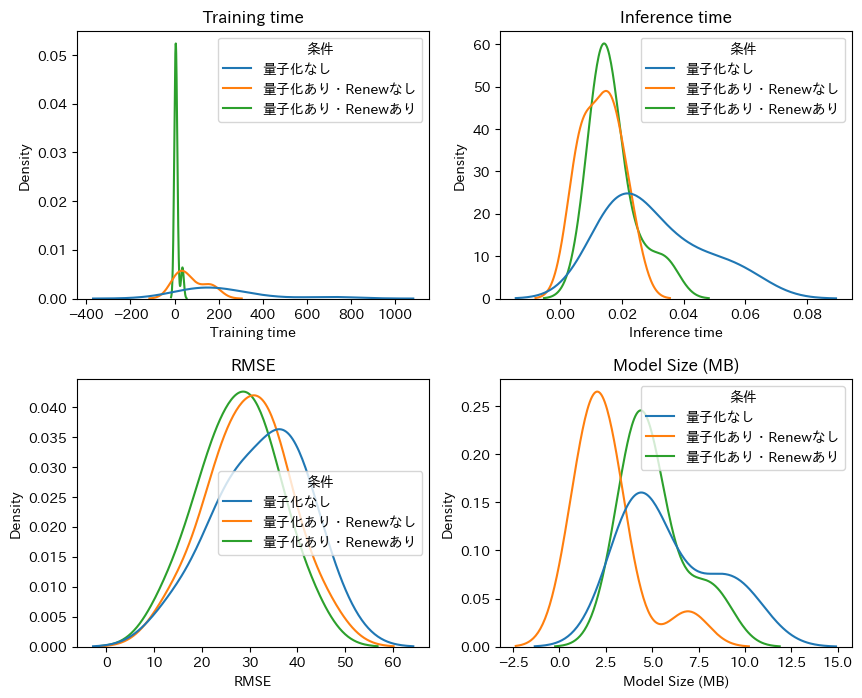

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

res = pd.concat(results)
fig, axes = plt.subplots(figsize=[10, 8], nrows=2, ncols=2)
fig.subplots_adjust(hspace=0.3)

i, j = 0, 0
col = 'Training time'
sns.kdeplot(data=res, x=col, hue="条件", common_norm=False, ax=axes[i, j])
axes[i, j].set(title=f"{col}")

i, j = 0, 1
col = 'Inference time'
sns.kdeplot(data=res, x=col, hue="条件", common_norm=False, ax=axes[i, j])
axes[i, j].set(title=f"{col}")

i, j = 1, 0
col = 'RMSE'
sns.kdeplot(data=res, x=col, hue="条件", common_norm=False, ax=axes[i, j])
axes[i, j].set(title=f"{col}")

i, j = 1, 1
col = 'Model Size (MB)'
sns.kdeplot(data=res, x=col, hue="条件", common_norm=False, ax=axes[i, j])
axes[i, j].set(title=f"{col}")

fig.show()